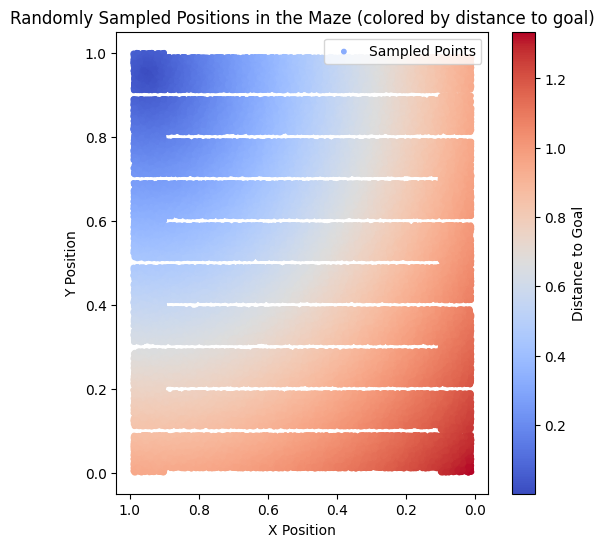

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from maze_env import MazeEnv
from maze import Maze

# Initialization of env.
maze = Maze(10, 10, 0, 0) 
env = MazeEnv(sz=10, maze=maze, start=np.array([0.05, 0.05]), goal=np.array([0.95, 0.95]),
               reward="distance", log=False, eval=False, dt=0.1, horizon=100, 
               wall_penalty=10, slide=1, image_freq=100)

# Function to generate valid points into the maze 
def generate_positions(env, num_samples=500, max_attempts=5000):
    positions = set()
    attempts = 0
    
    while len(positions) < num_samples and attempts < max_attempts:
        state = env.sample_open_state_continuous()
        
        # If the point lies on a wall, try again 
        if not env.point_collision(state[0], state[1]):
            positions.add(tuple(state))
        
        attempts += 1
    
    if len(positions) < num_samples:
        print(f"Warning: Only {len(positions)} unique positions generated out of {num_samples} requested.")
    
    return np.array(list(positions))

# Function to calculate the score points 
def compute_scores(env, positions):
    scores = []
    goal = np.array(env.goal)
    
    for pos in positions:
        x, y = pos
        
        # Distance from the goal 
        distance_to_goal = np.linalg.norm(goal - np.array([x, y]))
        
        # Distance from walls (using the new implemented function point_collision) 
        epsilon = 0.05  # Small step to check the distance to wall 
        distances = [
            env.point_collision(x + epsilon, y),
            env.point_collision(x - epsilon, y),
            env.point_collision(x, y + epsilon),
            env.point_collision(x, y - epsilon)
        ]
        distance_from_wall = sum(1 for d in distances if not d) / len(distances)
        
        # Check if I am in a death point 
        is_dead_end = sum(distances) >= 3  # If 3 or more, I am in a death point
        
        scores.append((x, y, distance_to_goal, distance_from_wall, is_dead_end))
    
    return scores

# Generate the points 
points_to_generate = 100000
positions = generate_positions(env, num_samples=points_to_generate, max_attempts=10*points_to_generate)

# Calculate the scores per each point 
scores = compute_scores(env, positions)

# Save points and scores 
df_positions = pd.DataFrame(scores, columns=["x", "y", "distance_to_goal", "distance_from_wall", "is_dead_end"])
df_positions.to_csv("positions.csv", index=False)

# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_goal"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to goal)")
plt.colorbar(label="Distance to Goal")
plt.show()
